In [1]:
%load_ext autoreload
%autoreload 2

from pymongo import MongoClient

mongo_client = MongoClient()

database = mongo_client["graduation"]

pull_requests_collection = database["pull_requests"]

projects_collection = database["projects"]

commits_collection = database["commits"]

In [2]:
import analysis_utilities

projects = list(projects_collection.find({'succeeded' : True, 'travis_is_oldest_ci' : True}))

print("Found {} projects with a travis build status date".format(len(projects)))

Found 685 projects with a travis build status date


In [3]:
control_sizes_pl = []
control_sizes = []

for project in projects:
    valid_control_set_pl = list(projects_collection.find({'status_travis_date' : {'$gt' : project["status_travis_date"]},
                                                        'language' : project["language"]}))
    
    valid_control_set = list(projects_collection.find({'status_travis_date' : {'$gt' : project["status_travis_date"]}}))
    
    control_sizes.append(len(valid_control_set))
    control_sizes_pl.append(len(valid_control_set_pl))
    
    project["control"] = valid_control_set

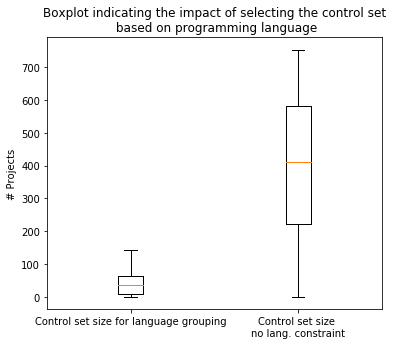

In [4]:
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np


plt.figure(figsize=(6,5))

plt.ylabel('# Projects')
plt.title('Boxplot indicating the impact of selecting the control set\n based on programming language')

plt.boxplot([control_sizes_pl, control_sizes])
plt.xticks(np.arange(2) + 1, ['Control set size for language grouping', 'Control set size \nno lang. constraint'])

plt.show()

In [11]:
def calculate_share_review_comments(prs, project):
    total_review_comments = sum([len(pr["review_comments"]) for pr in prs])
    total_general_comments = sum([len(pr["raw_comments"]) for pr in prs])

    total = total_review_comments + total_general_comments   

    if total == 0:
        share_review_comments = 0
    else: 
        share_review_comments = total_review_comments / total
        
    return share_review_comments

def project_name(prs, project):
    return project["full_name"]

def sum_field(fieldname, is_list = False):
    def sum_field_func(prs, project):
        if is_list:
            return sum([len(pr[fieldname]) for pr in prs])
        else:
            return sum([pr[fieldname] for pr in prs])
        
    return sum_field_func

def total_prs(prs, project):
    return len(prs)

def project_language(prs, project):
    return project["language"]

def sum_effective_comments(prs, project):
    total = 0    
    for pr in prs:    
        total += len([comment for comment in pr["review_comments"] if 'is_effective' in comment and comment["is_effective"]])
        
    return total
    
metrics_to_calculate = [
    {'Name': 'ProjectName', 'Func': project_name},
    {'Name': 'Language', 'Func': project_language},
    {'Name': 'ShareReviewComments', 'Func': calculate_share_review_comments},
    {'Name': 'Additions', 'Func': sum_field("additions")},
    {'Name': 'Deletions', 'Func': sum_field("deletions")},
    {'Name': 'ChangedFiles', 'Func': sum_field("changed_files")},
    {'Name': 'Assignees', 'Func': sum_field("assignees", True) },
    {'Name': 'ReviewComments', 'Func': sum_field("review_comments", True)},
    {'Name': 'GeneralComments', 'Func': sum_field("raw_comments", True)},
    {'Name': 'TotalPrs', 'Func': total_prs},
    {'Name': 'Commits', 'Func': sum_field("commits", True)},
    {'Name': 'EffectiveComments', 'Func': sum_effective_comments}
]

In [ ]:
from datetime import datetime, timedelta

period_vals = [10,12,14,16,18,20,22,24,26,28,30]
periods_vals = [10,15,20,25,30,35,40,45,50,55,60]
   
period = 15
periods = 45

out = [[0 for y in periods_vals] for x in period_vals]

period_i = 0
periods_i = 0

for period in period_vals:
    for periods in periods_vals:
        post_intervention_periods = periods / 3
        
        for project in projects:
            
            project.pop("metrics", None)

            metric_collection = {}

            for metric in metrics_to_calculate:
                metric_collection[metric["Name"]] = [0 for x in range(periods)]

            not_enough_data = False

            prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]},
                                                    {'bigrams': 0, 'body': 0, 'review_comments.bigrams': 0, 'review_comments.body': 0, 'raw_comments.bigrams': 0,
                                                    'raw_comments.body': 0}))

            #prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, True)

            travis_date = project["status_travis_date"]

            start_date = travis_date - timedelta(days=(periods - post_intervention_periods) * period)

            empty_period = False

            split_prs = []

            for i in range(periods):
                end_date = start_date + timedelta(days=period)

                prs_in_period = []

                for pr in prs:
                    if pr["created_at"] > start_date and pr["created_at"] < end_date:
                        prs_in_period.append(pr)

                if len(prs_in_period) == 0:
                    empty_period = True
                    break

                split_prs.append(prs_in_period)

                start_date = end_date

            if empty_period:
                continue           

            empty_effective = False;
            
            for i in range(len(split_prs)):
                prs_in_period = split_prs[i]

                for metric in metrics_to_calculate:
                    metric_collection[metric["Name"]][i] = (metric["Func"](prs_in_period, project))
                    
                      
                if metric_collection["EffectiveComments"][i] == 0:
                    empty_effective = True
                    break


            if empty_effective:
                continue
                
            project["metrics"] = metric_collection
            
        out[period_i][periods_i] =len([pr for pr in projects if "metrics" in pr])
        
        periods_i += 1
        
    print("Completed a row")
        
    period_i += 1
    periods_i = 0


        

Completed a row
Completed a row
Completed a row
Completed a row
Completed a row
Completed a row
Completed a row


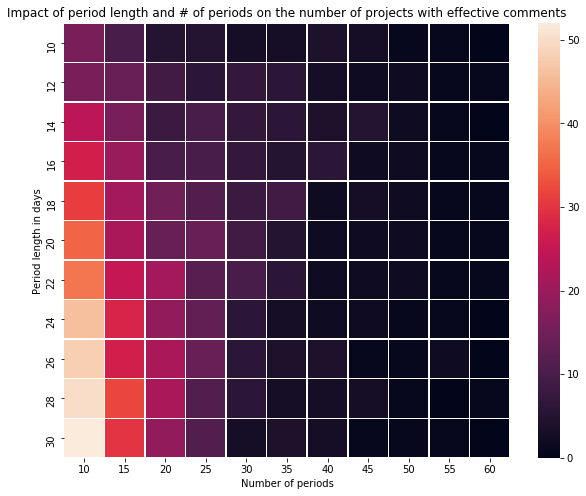

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

fig = plt.figure(figsize=(10,8))

ax = sns.heatmap(out, linewidth=0.5, yticklabels = period_vals, xticklabels = periods_vals)

ax.set_title("Impact of period length and # of periods on the number of projects with effective comments")

ax.set_ylabel("Period length in days")

ax.set_xlabel("Number of periods")

plt.show()

fig.savefig('dataset/causal-heatmap.pdf', bbox_inches="tight")

In [61]:
from datetime import datetime, timedelta
import csv
   
period = 15
periods = 45

post_intervention_periods = 15

for project_under_test in projects:

    metric_collection = {}

    filename = "generated/causal/{}.csv".format(project_under_test["full_name"].replace("/", "_"))

    for metric in metrics_to_calculate:
        metric_collection[metric["Name"]] = [[] for x in range(periods)]
        
    not_enough_data = False



    for project in [project_under_test] + project_under_test["control"]:
        prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))

        #prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, True)

        travis_date = project["status_travis_date"]

        start_date = travis_date - timedelta(days=(periods - post_intervention_periods) * period)

        empty_period = False

        split_prs = []

        for i in range(periods):
            end_date = start_date + timedelta(days=period)

            prs_in_period = []

            for pr in prs:
                if pr["created_at"] > start_date and pr["created_at"] < end_date:
                    prs_in_period.append(pr)

            if len(prs_in_period) == 0:
                empty_period = True
                break

            split_prs.append(prs_in_period)

            start_date = end_date

        if empty_period:
            if project["full_name"] == project_under_test["full_name"]:
                not_enough_data = True
            continue           
        

        for i in range(len(split_prs)):
            prs_in_period = split_prs[i]

            for metric in metrics_to_calculate:
                metric_collection[metric["Name"]][i].append(metric["Func"](prs_in_period, project))
    
    # Continue if the project under test does not have a regular 
    # enough amount of PRs to continue
    if not_enough_data:
        continue
    
                
    with open(filename, mode='w') as time_series_file:
        writer = csv.writer(time_series_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

        writer.writerow([metric["Name"] for metric in metrics_to_calculate] + ["Period"])

        for j in range(len(metric_collection[metrics_to_calculate[0]["Name"]][0])):
            for i in range(periods):
                metric_names = [metric["Name"] for metric in metrics_to_calculate]

                line_to_write = [metric_collection[metric][i][j] for metric in metric_names] + [i + 1]

                writer.writerow(line_to_write)


        